In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [5]:
sales_data = pd.read_csv("../data/self preprocessed/synthetic_sales_2_years.csv")
sales_data

,Brand,Description,SalesDate,SalesQuantity
0,58,Gekkeikan Black & Gold Sake,2016-03-01,3
1,58,Gekkeikan Black & Gold Sake,2016-03-03,3
2,58,Gekkeikan Black & Gold Sake,2016-03-04,1
3,58,Gekkeikan Black & Gold Sake,2016-03-07,1
4,58,Gekkeikan Black & Gold Sake,2016-03-08,1
...,...,...,...,...
2255528,90086,La Dame Montrose St Estep 11,2018-02-16,1
2255529,90086,La Dame Montrose St Estep 11,2018-02-17,1
2255530,90086,La Dame Montrose St Estep 11,2018-02-20,1
2255531,90086,La Dame Montrose St Estep 11,2018-02-25,2


In [7]:
sales_data.columns

Index(['Brand', 'Description', 'SalesDate', 'SalesQuantity'], dtype='object')

Top 5 selling items:
Brand  Description                
5954   Fireball Cinnamon Whisky       76050
14962  Stone Barn Chard               75445
15529  Goose Ridge Red g3             56963
42751  Five Oaks Cab Svgn Cal         52113
5683   Dr McGillicuddy's Apple Pie    49945
Name: SalesQuantity, dtype: int64


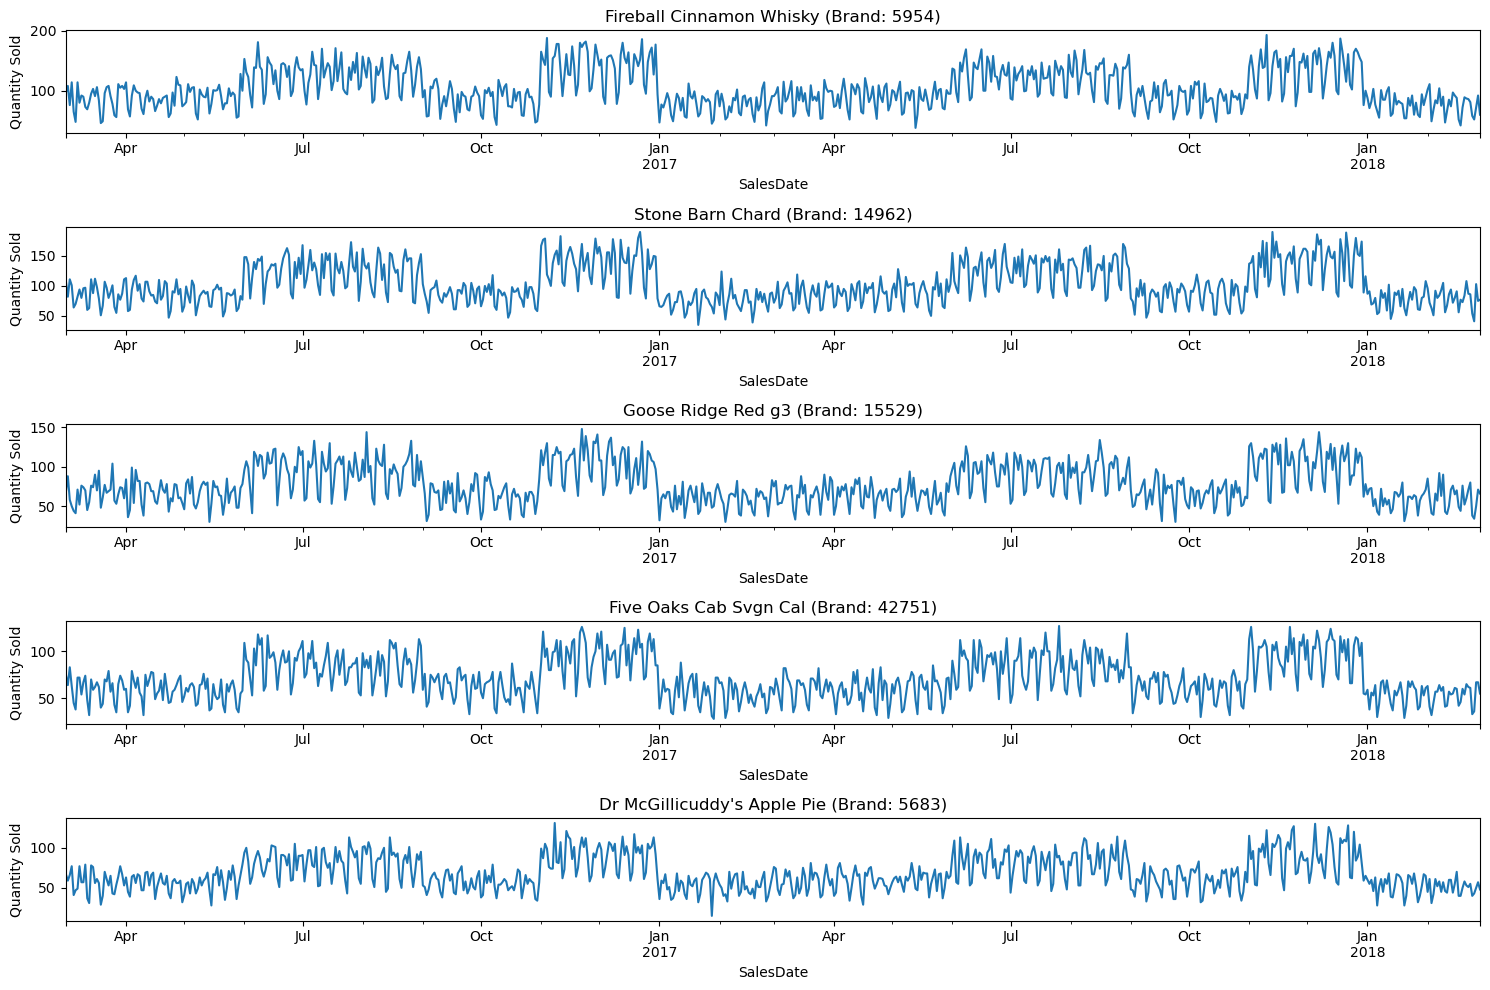


Preparing forecast for: Fireball Cinnamon Whisky (Brand: 5954)
Daily sales statistics:
count    730.000000
mean     104.178082
std       33.001660
min       38.000000
25%       82.000000
50%       98.000000
75%      129.750000
max      193.000000
Name: SalesQuantity, dtype: float64


In [8]:

sales_data['SalesDate'] = pd.to_datetime(sales_data['SalesDate'])

# Group by date and item (using Brand and Description)
item_daily_sales = sales_data.groupby(['SalesDate', 'Brand', 'Description'])['SalesQuantity'].sum().reset_index()

# Let's look at top selling items
top_items = sales_data.groupby(['Brand', 'Description'])['SalesQuantity'].sum().sort_values(ascending=False).head(5)
print("Top 5 selling items:")
print(top_items)

# Create time series for each of top 5 items
plt.figure(figsize=(15, 10))
for idx, (brand, desc) in enumerate(top_items.index):
    item_sales = item_daily_sales[
        (item_daily_sales['Brand'] == brand) & 
        (item_daily_sales['Description'] == desc)
    ].set_index('SalesDate')['SalesQuantity']
    
    plt.subplot(5, 1, idx+1)
    item_sales.plot()
    plt.title(f"{desc} (Brand: {brand})")
    plt.ylabel("Quantity Sold")

plt.tight_layout()
plt.show()

# Function to prepare single item time series
def prepare_item_series(brand, description):
    item_series = item_daily_sales[
        (item_daily_sales['Brand'] == brand) & 
        (item_daily_sales['Description'] == description)
    ].set_index('SalesDate')['SalesQuantity']
    
    # Reindex to fill missing dates with 0
    idx = pd.date_range(item_series.index.min(), item_series.index.max())
    item_series = item_series.reindex(idx, fill_value=0)
    
    return item_series

# Let's take the top selling item for our initial model
top_brand, top_desc = top_items.index[0]
top_item_series = prepare_item_series(top_brand, top_desc)

print(f"\nPreparing forecast for: {top_desc} (Brand: {top_brand})")
print("Daily sales statistics:")
print(top_item_series.describe())

In [9]:
def create_item_features(series):
    """
    Create features for item-level sales forecasting
    """
    df = pd.DataFrame(index=series.index)
    df['sales'] = series
    
    # Time-based features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Lag features (previous days' sales)
    df['sales_lag1'] = df['sales'].shift(1)
    df['sales_lag7'] = df['sales'].shift(7)
    
    # Rolling statistics
    df['rolling_mean_7'] = df['sales'].rolling(7).mean()
    df['rolling_max_7'] = df['sales'].rolling(7).max()
    df['rolling_std_7'] = df['sales'].rolling(7).std()
    
    # Drop NaN values
    df = df.dropna()
    
    return df

# Create features for our top item
top_item_features = create_item_features(top_item_series)
print("\nFeatures created:")
print(top_item_features.columns.tolist())


Features created:
['sales', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'sales_lag1', 'sales_lag7', 'rolling_mean_7', 'rolling_max_7', 'rolling_std_7']


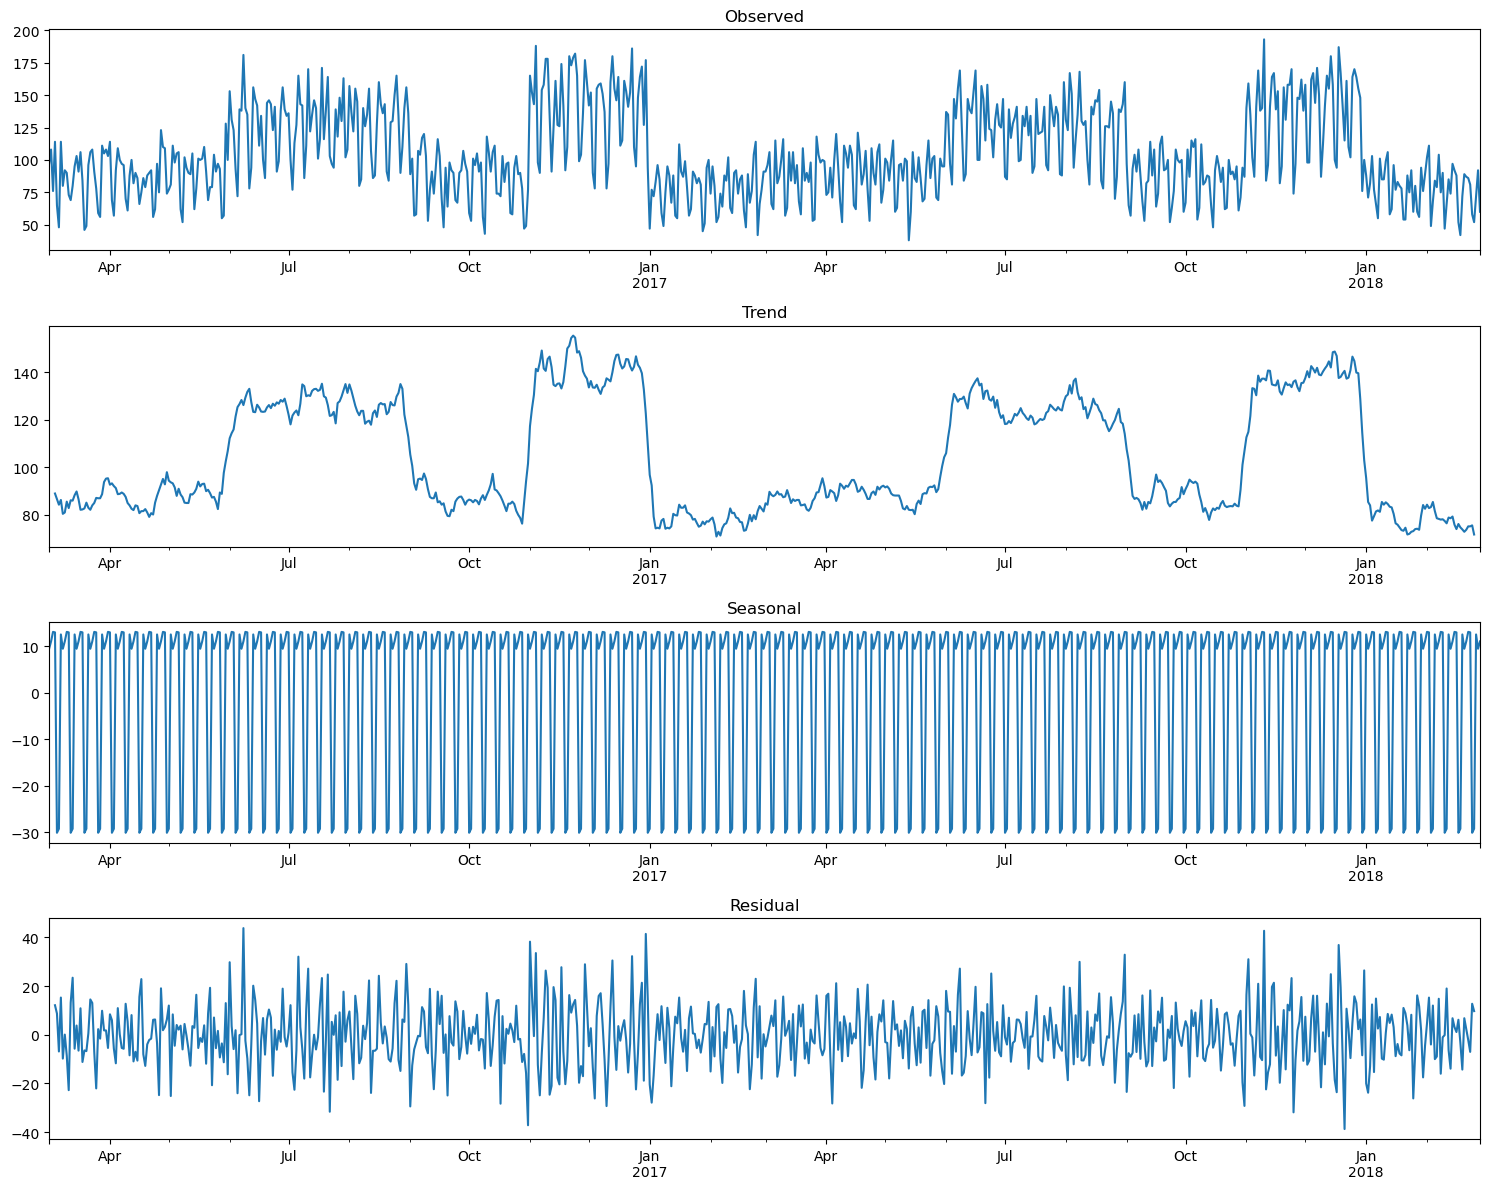

Finding optimal SARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=6768.043, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=6418.442, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=6616.096, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=6351.261, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=6485.789, Time=0.25 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=6278.275, Time=0.48 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=6346.714, Time=0.21 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=0.75 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=6267.825, Time=0.54 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=6336.978, Time=0.34 sec
 ARIMA(3,1,0)(2,1,1)[

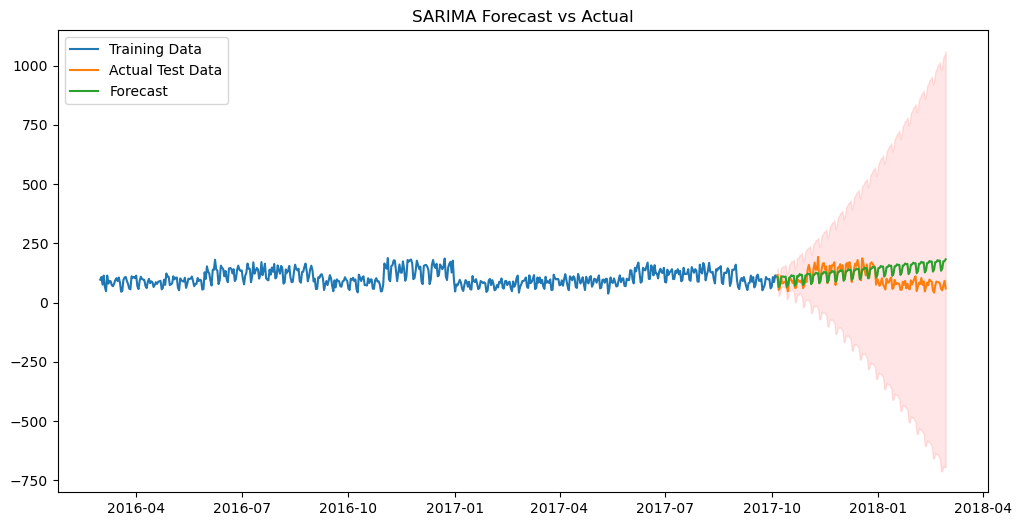


Model Performance Metrics:
MAE: 41.77
RMSE: 52.17
MAPE: 51.51%


['../models/item_sarima_model.joblib']

In [10]:

# Prepare the time series for our top selling item
def prepare_item_sarima(item_series):
    # Decompose the series to understand seasonality
    decomposition = seasonal_decompose(item_series, period=7)
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.show()
    
    return decomposition

# Find optimal SARIMA parameters
def find_sarima_params(series):
    print("Finding optimal SARIMA parameters...")
    model = pm.auto_arima(series,
                         seasonal=True,
                         m=7,  # Weekly seasonality
                         d=1,  # First differencing
                         D=1,  # Seasonal differencing
                         start_p=0, max_p=3,
                         start_q=0, max_q=3,
                         start_P=0, max_P=2,
                         start_Q=0, max_Q=2,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True)
    return model.order, model.seasonal_order

# Train SARIMA model and generate forecasts
def train_sarima(series, order, seasonal_order):
    # Split data into train and test
    train_size = int(len(series) * 0.8)
    train = series[:train_size]
    test = series[train_size:]
    
    # Fit the model
    model = SARIMAX(train,
                    order=order,
                    seasonal_order=seasonal_order)
    results = model.fit()
    
    # Generate forecasts
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Test Data')
    plt.plot(test.index, forecast_mean, label='Forecast')
    plt.fill_between(test.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='r',
                    alpha=0.1)
    plt.title('SARIMA Forecast vs Actual')
    plt.legend()
    plt.show()
    
    # Calculate metrics
    mae = mean_absolute_error(test, forecast_mean)
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    mape = np.mean(np.abs((test - forecast_mean) / test)) * 100
    
    print(f"\nModel Performance Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    return results, forecast_mean, conf_int

# Execute the analysis
decomp = prepare_item_sarima(top_item_series)
order, seasonal_order = find_sarima_params(top_item_series)
model_results, forecasts, confidence_intervals = train_sarima(top_item_series, order, seasonal_order)

# Save the model
import joblib
joblib.dump(model_results, '../models/item_sarima_model.joblib')

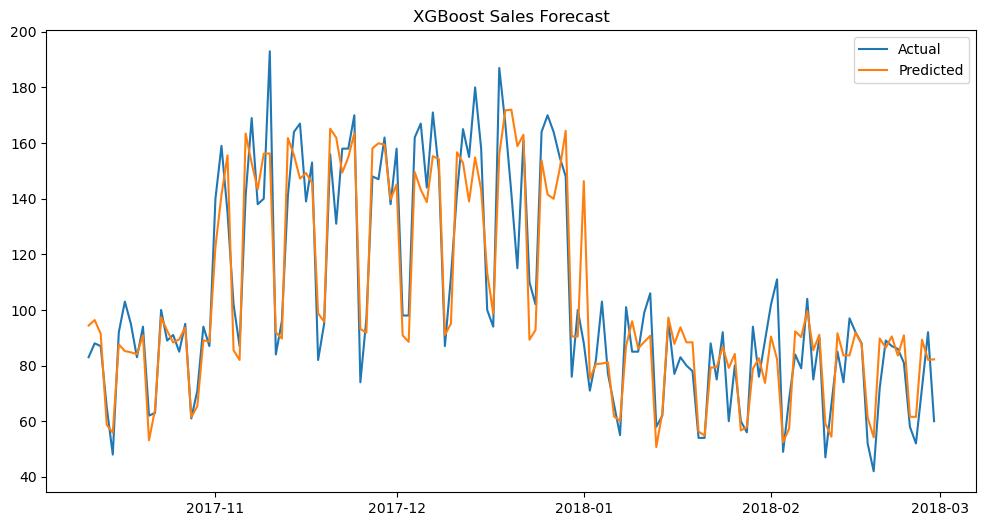

In [11]:


def create_features(series):
    """Create features for XGBoost"""
    df = pd.DataFrame(index=series.index)
    df['sales'] = series
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    
    # Lag features
    for lag in [1, 7, 14]:
        df[f'lag_{lag}'] = df['sales'].shift(lag)
    
    # Rolling features
    for window in [7, 14, 30]:
        df[f'rolling_mean_{window}'] = df['sales'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['sales'].rolling(window=window).std()
    
    return df.dropna()

# Prepare data
features_df = create_features(top_item_series)
train_size = int(len(features_df) * 0.8)
train = features_df[:train_size]
test = features_df[train_size:]

# Separate features and target
feature_columns = [col for col in features_df.columns if col != 'sales']
X_train, y_train = train[feature_columns], train['sales']
X_test, y_test = test[feature_columns], test['sales']

# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, y_pred, label='Predicted')
plt.title('XGBoost Sales Forecast')
plt.legend()
plt.show()

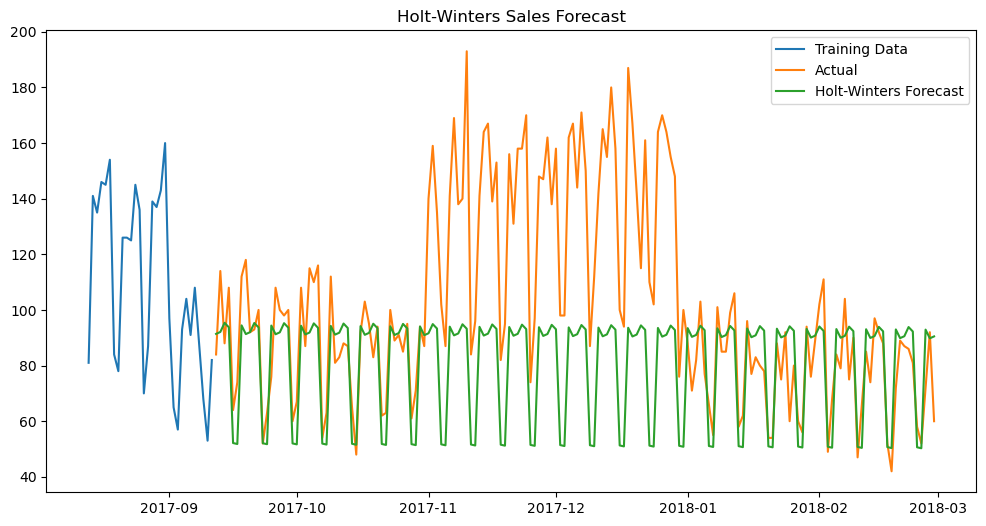


XGBoost Metrics:
MAE: 10.70
RMSE: 13.96
MAPE: 10.61%

Holt-Winters Metrics:
MAE: 26.53
RMSE: 36.66
MAPE: 22.64%


['../models/holtwinters_sales_model.joblib']

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Prepare data
train = top_item_series[:train_size]
test = top_item_series[train_size:]

# Train Holt-Winters model
hw_model = ExponentialSmoothing(
    train,
    seasonal_periods=7,
    trend='add',
    seasonal='add'
).fit()

# Generate forecasts
hw_forecast = hw_model.forecast(len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index[-30:], train[-30:], label='Training Data')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast')
plt.title('Holt-Winters Sales Forecast')
plt.legend()
plt.show()

# Calculate metrics for both models
def print_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{model_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(y_test, y_pred, "XGBoost")
print_metrics(test, hw_forecast, "Holt-Winters")

# Save models
import joblib
joblib.dump(xgb_model, '../models/xgb_sales_model.joblib')
joblib.dump(hw_model, '../models/holtwinters_sales_model.joblib')

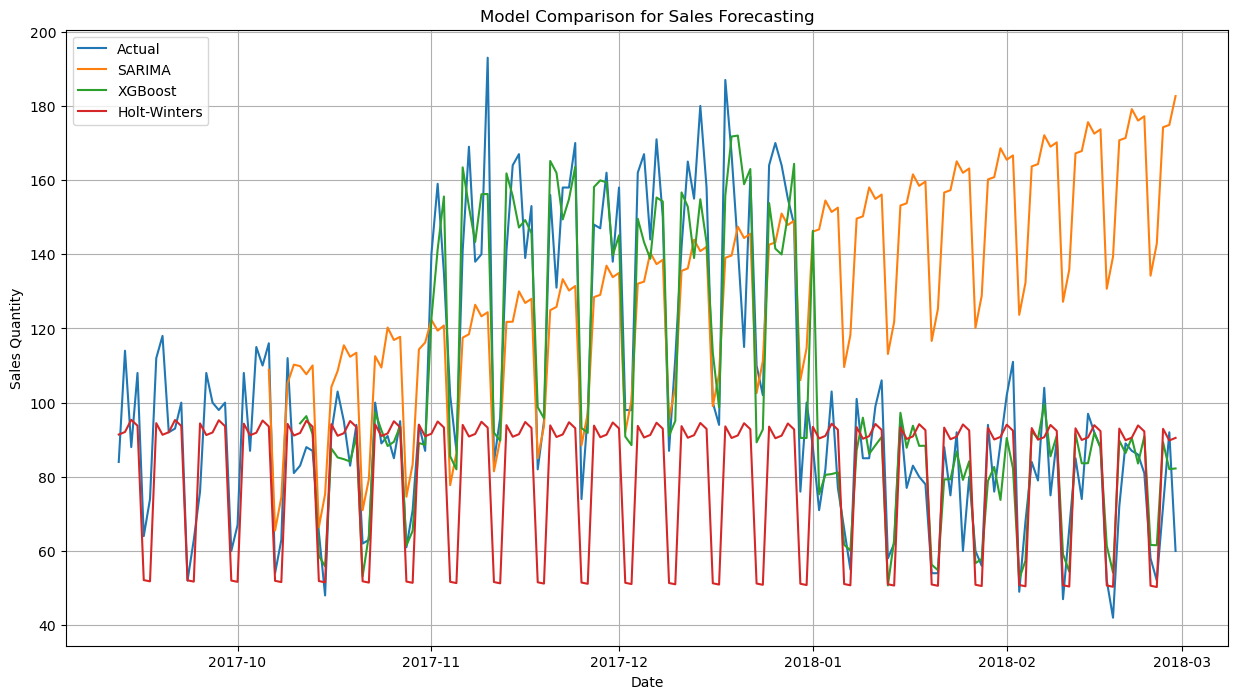


SARIMA Metrics:


TypeError: print_metrics() missing 1 required positional argument: 'model_name'

In [13]:
def plot_model_comparison(actual, sarima_pred, xgb_pred, hw_pred):
    """
    Plot comparison of different models' predictions
    All inputs should have the same time index
    """
    # Ensure all predictions are aligned with the same index
    comparison_df = pd.DataFrame({
        'Actual': actual,
        'SARIMA': sarima_pred,
        'XGBoost': xgb_pred,
        'Holt-Winters': hw_pred
    }, index=actual.index)
    
    # Plot
    plt.figure(figsize=(15, 8))
    for column in comparison_df.columns:
        plt.plot(comparison_df.index, comparison_df[column], label=column)
    
    plt.title('Model Comparison for Sales Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print metrics for each model
    for model in ['SARIMA', 'XGBoost', 'Holt-Winters']:
        print(f"\n{model} Metrics:")
        print_metrics(comparison_df['Actual'], comparison_df[model])

# Make sure predictions are for the same period
test_period = test.index  # Use test period as reference

# Align predictions to same period
sarima_aligned = pd.Series(forecasts, index=test_period[-len(forecasts):])
xgb_aligned = pd.Series(y_pred, index=test_period[-len(y_pred):])
hw_aligned = pd.Series(hw_forecast, index=test_period[-len(hw_forecast):])
actual_aligned = test[-len(test_period):]

# Now plot the comparison
plot_model_comparison(
    actual_aligned,
    sarima_aligned,
    xgb_aligned,
    hw_aligned
)